In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib as mpl
import os
import lightgbm as lgb

from IPython.core.pylabtools import figsize
from scipy import stats

from sklearn.model_selection import train_test_split


In [2]:
#Getting Working Directory
os.getcwd()

#Setting style and font size for graphs
sns.set_style("whitegrid")
mpl.rcParams['font.size'] = 13

In [3]:
#load original data into dataframe
file ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\train_final.csv'

df = pd.read_csv(file)
df.shape

(7377418, 73)

In [4]:
drop_col = ['msno','song_id','genre_ids', 'composer', 'artist_name', 'lyricist', 'isrc_country']
df.drop(drop_col, axis=1, inplace = True)

# Converting to categories
cat_names = list(df.select_dtypes(include='object').columns)
df[cat_names] = df[cat_names].astype('category')

# Converting int64 to int32 type
int32 = ['count_artist_played', 'count_song_played']
df[int32] = df[int32].astype('int32')

int8 = ['language','bd','city', 'genre_count', 'lyricist_count','composer_count','artist_count','registered_via']
df[int8] = df[int8].astype('int8')

# Converting int64 to int16 type
int64 = list(df.select_dtypes(include='int64').columns)
df[int64] = df[int64].astype('int16')

# Converting float64 to float32 and float16 type
float_names = list(df.select_dtypes(include='float64').columns)
float_names.remove('song_length')
df[float_names] = df[float_names].astype('float16')
df['song_length'] = df['song_length'].astype('float32')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 66 columns):
source_system_tab       category
source_screen_name      category
source_type             category
target                  int16
song_length             float32
language                int8
city                    int8
bd                      int8
registered_via          int8
lyricist_count          int8
artist_count            int8
composer_count          int8
genre_count             int8
isrc_year               int16
song_freq               int16
artist_freq             int16
count_song_played       int32
count_artist_played     int32
duration                int16
registration_year       int16
expiration_year         int16
expiration_month        int16
age_of_song             int16
song_type               category
genre_ids_encoded       float16
composer_encoded        float16
artist_name_encoded     float16
lyricist_encoded        float16
isrc_country_encoded    float16
u

In [5]:
# Separating Numeric and Non_numeric Data
numeric = df.select_dtypes(exclude = 'category')
categorical = df.select_dtypes(include = 'category')

#Creating Dummy variables for Categorical Data using One Hot Encoding
dummies = pd.get_dummies(categorical,drop_first = True)

In [6]:
#Creating our Feature and Target Data Set: X, y respectively
X = pd.concat([numeric,dummies],axis=1).drop('target', axis = 1)
y = df.target

#Splitting Data into Training and Test Data Set
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [7]:
X_train.shape

(3688709, 102)

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3688709 entries, 288797 to 6413414
Columns: 102 entries, song_length to song_type_short
dtypes: float16(42), float32(1), int16(8), int32(2), int8(8), uint8(41)
memory usage: 594.5 MB


There are two types of error, False Positive and False Negative. Predicting that a song will not be listened again but actually song gets listened again. This is false negative. Predicting that a song will be listened again but in actually song is not listened again is called false positive. For us both type of error are important

## Normalization

In [9]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# Copy of Data set
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

numeric = numeric.drop('target', axis = 1)
for i in numeric:
    
    # fit on training data column
    scale = MinMaxScaler().fit(X_train_norm[[i]])
    
    # transform the training data column
    X_train_norm[i] = scale.transform(X_train_norm[[i]])
    
    # transform the testing data column
    X_test_norm[i] = scale.transform(X_test_norm[[i]])


In [10]:
float_names = list(X_train_norm.select_dtypes(include='float64').columns)
X_train_norm[float_names] = X_train_norm[float_names].astype('float16')
X_test_norm[float_names] = X_test_norm[float_names].astype('float16')

float_names = list(X_train_norm.select_dtypes(include='float32').columns)
X_train_norm[float_names] = X_train_norm[float_names].astype('float16')
X_test_norm[float_names] = X_test_norm[float_names].astype('float16')

### LightGB Classifier

In [11]:
# Base Line Evaluation
from sklearn.metrics import classification_report, balanced_accuracy_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support,log_loss
class_names = ['Not Listened', 'Listened']

In [12]:
def auc_curve(y_test,y_pred_test,auc_test):
    fpr,tpr, threshold = roc_curve(y_test, y_pred_test)
    _ = plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' %auc_test )
    _ = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    _ = plt.xlim([0.0, 1.0])
    _ = plt.ylim([0.0, 1.05])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic example')
    _ = plt.legend(loc="lower right")


Training accuracy: 0.6962
Test accuracy    : 0.6959
Training AUC Score: 0.767898256
Testing AUC Score: 0.767555200
Classification Report - Training
              precision    recall  f1-score   support

           0       0.69      0.70      0.70   1830920
           1       0.70      0.69      0.70   1857789

    accuracy                           0.70   3688709
   macro avg       0.70      0.70      0.70   3688709
weighted avg       0.70      0.70      0.70   3688709

Classification Report - Testing
              precision    recall  f1-score   support

Not Listened       0.69      0.70      0.70   1831842
    Listened       0.70      0.69      0.70   1856867

    accuracy                           0.70   3688709
   macro avg       0.70      0.70      0.70   3688709
weighted avg       0.70      0.70      0.70   3688709



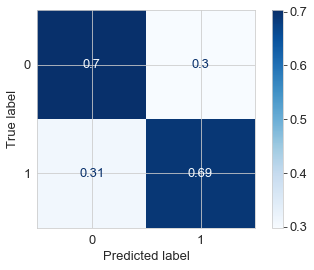

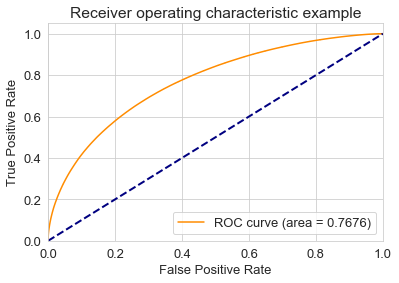

In [13]:
# Base Line Evaluation
dtrain = lgb.Dataset(data = X_train, label = y_train)
dtest = lgb.Dataset(data = X_test, label = y_test)


lg = lgb.LGBMClassifier(objective = 'binary', metric = 'binary_logloss', random_state = 42, n_jobs = 4, verbose = 3)
lg.fit(X_train_norm,y_train)

#Predicting for testing and trainig data sets
y_test_proba = lg.predict_proba(X_test_norm)[:,1]
y_train_proba = lg.predict_proba(X_train_norm)[:,1]

y_pred_test = lg.predict(X_test_norm)
y_pred_train = lg.predict(X_train_norm)

    #Accuracy Score
print("Training accuracy: %0.4f" %lg.score(X_train_norm, y_train))
print("Test accuracy    : %0.4f" %lg.score(X_test_norm, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.9f' %auc_train)  
print('Testing AUC Score: %0.9f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(lg, X_test_norm, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


Top 20 Important Features


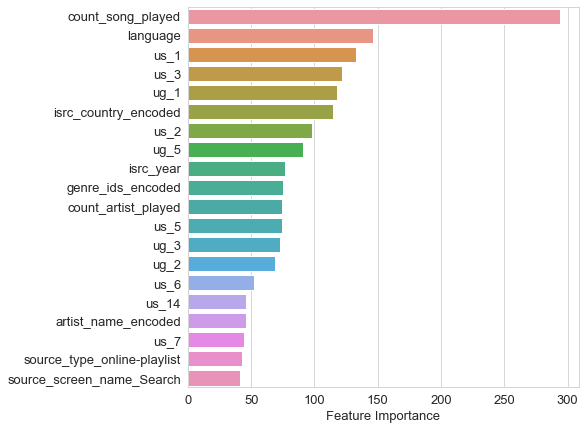

In [15]:
figsize(7,7)
import seaborn as sns

coefficients = lg.feature_importances_
coef = pd.DataFrame(coefficients, index = X_train.columns, columns = ['Feature Importance'])
coef.sort_values('Feature Importance', ascending = False, inplace = True)
print("Top 20 Important Features")

_ = sns.barplot(data = coef[:20], x = 'Feature Importance', y = coef[:20].index, orient = 'h')

